# Tomato leaf disease recognition model

This notebook trains a CNN to classify tomato leaf images into 10 classes (9 diseases + healthy). It uses the Tomato_Images dataset, with proper train/validation/test splits, data augmentation, and evaluation via confusion matrix and classification report.

---

**Importation of dependencies**

In [36]:
import os
import random
import json
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Reproducibility
SEED = 42
os.environ["PYTHONHASHSEED"] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

**Constants**

Batch size, image size (256×256), number of epochs, and validation split (80% train, 20% reserved for validation and test).

In [37]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS = 3
EPOCHS = 40
VALIDATION_SPLIT = 0.2  # 80% train, 20% for val+test

**Load image datasets**

Load from `Tomato_Images` with Keras `validation_split=0.2`: 80% for training, 20% for validation. The validation subset will be split later into validation and test.

In [38]:
# Load training set (80%) and validation+test set (20%) using built-in split
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "../Tomato_Images",
    seed=SEED,
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    validation_split=VALIDATION_SPLIT,
    subset="training",
)
full_val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "../Tomato_Images",
    seed=SEED,
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    validation_split=VALIDATION_SPLIT,
    subset="validation",
)

Found 16011 files belonging to 10 classes.
Using 12809 files for training.
Found 16011 files belonging to 10 classes.
Using 3202 files for validation.


In [39]:
class_names = train_ds.class_names
class_names

['Bacterial_spot',
 'Early_blight',
 'Healthy',
 'Late_blight',
 'Leaf_mold',
 'Mosaic_virus',
 'Septoria_leaf_spot',
 'Target_spot',
 'Two_spotted_spider_mite',
 'Yellow_leaf_curl_virus']

**Class balance**

Count samples per class in the training set and plot the distribution. Imbalanced classes may need class weights or resampling.

2026-02-04 14:49:37.663597: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


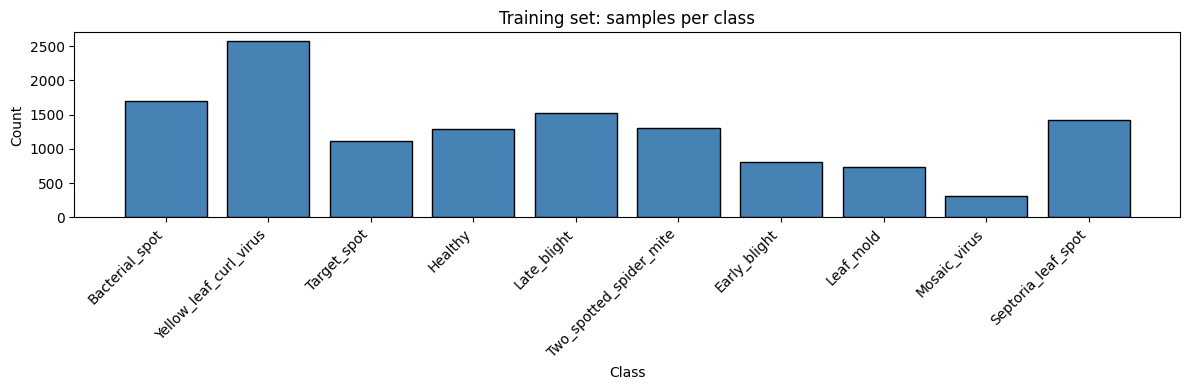

In [40]:
# Count samples per class from training set
class_counts = {}
for _, labels_batch in train_ds:
    for label in labels_batch.numpy():
        name = class_names[label]
        class_counts[name] = class_counts.get(name, 0) + 1
plt.figure(figsize=(12, 4))
plt.bar(class_counts.keys(), class_counts.values(), color='steelblue', edgecolor='black')
plt.xticks(rotation=45, ha='right')
plt.xlabel("Class")
plt.ylabel("Count")
plt.title("Training set: samples per class")
plt.tight_layout()
plt.show()

In [41]:
for image_batch, labels_batch in train_ds.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[6 8 7 3 8 9 8 1 2 2 2 3 1 2 0 1 6 7 9 9 8 1 9 7 6 9 0 6 0 3 5 0]


In [42]:
print("Train batches:", len(train_ds))
print("Validation+test batches:", len(full_val_ds))

Train batches: 401
Validation+test batches: 101


**Split validation subset**

The 20% validation subset is split in half: one half for validation during training (early stopping, checkpointing), the other for final test evaluation.

In [43]:
# Split the 20% validation subset into half for val and half for test
full_val_ds = full_val_ds.shuffle(1000, seed=SEED)
n_val_batches = len(full_val_ds)
val_ds = full_val_ds.take(n_val_batches // 2)
test_ds = full_val_ds.skip(n_val_batches // 2)

In [44]:
print("Val batches:", len(val_ds))
print("Test batches:", len(test_ds))

Val batches: 50
Test batches: 51


**Pipeline optimization**

Cache avoids re-reading from disk

Shuffle randomizes order for training

Prefetch loads batches in parallel with training for faster epochs.

In [45]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

**Preprocessing layers**  

*Resize and rescale*: normalize to 256×256 and pixel values 0–1 so any input size works at inference.

*Data augmentation*: random flips, rotation, zoom, and contrast; applied only during training to improve generalization.

In [46]:
resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.Rescaling(1./255),
])

In [47]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
  layers.RandomZoom(0.1),
  layers.RandomContrast(0.2),
])

**Model**

CNN with: Input → resize & rescale → augmentation → conv blocks (Conv2D + BatchNorm + MaxPool + Dropout, L2 regularization) → Flatten → Dense → softmax. Compiled with Adam and sparse categorical crossentropy.

In [48]:
input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = len(class_names)
l2_reg = tf.keras.regularizers.l2(1e-4)

model = models.Sequential([
    layers.Input(shape=input_shape),
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2_reg),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.2),
    layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2_reg),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.2),
    layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2_reg),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2_reg),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2_reg),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2_reg),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu', kernel_regularizer=l2_reg),
    layers.Dropout(0.4),
    layers.Dense(n_classes, activation='softmax'),
])

In [49]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

**Training**: Fit on `train_ds`, validate on `val_ds`. 

**Callbacks**: *EarlyStopping* (stop if val_loss doesn't improve for 8 epochs, restore best weights), *ModelCheckpoint* (save best model by val_accuracy to `best_model.keras`), *ReduceLROnPlateau* (halve learning rate if val_loss plateaus for 4 epochs).

In [50]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=8,
        restore_best_weights=True,
        verbose=1,
    ),
    tf.keras.callbacks.ModelCheckpoint(
        "../models/best_model.keras",
        monitor="val_accuracy",
        save_best_only=True,
        verbose=0,
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.5,
        patience=4,
        min_lr=1e-6,
        verbose=1,
    ),
]
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=callbacks,
    verbose=1,
)

Epoch 1/40


2026-02-04 14:49:51.866269: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:192: Filling up shuffle buffer (this may take a while): 366 of 1000
2026-02-04 14:49:52.930149: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:483] Shuffle buffer filled.


401/401 ━━━━━━━━━━━━━━━━━━━━ 928s 2s/step - accuracy: 0.4895 - loss: 1.6308 - val_accuracy: 0.1229 - val_loss: 6.2376 - learning_rate: 0.0010
Epoch 2/40
401/401 ━━━━━━━━━━━━━━━━━━━━ 851s 2s/step - accuracy: 0.7212 - loss: 0.8491 - val_accuracy: 0.5732 - val_loss: 2.0053 - learning_rate: 0.0010
Epoch 3/40
401/401 ━━━━━━━━━━━━━━━━━━━━ 845s 2s/step - accuracy: 0.7834 - loss: 0.6926 - val_accuracy: 0.6178 - val_loss: 1.5000 - learning_rate: 0.0010
Epoch 4/40
401/401 ━━━━━━━━━━━━━━━━━━━━ 868s 2s/step - accuracy: 0.8156 - loss: 0.5857 - val_accuracy: 0.4433 - val_loss: 4.0301 - learning_rate: 0.0010
Epoch 5/40
401/401 ━━━━━━━━━━━━━━━━━━━━ 908s 2s/step - accuracy: 0.8502 - loss: 0.4735 - val_accuracy: 0.2777 - val_loss: 6.8354 - learning_rate: 0.0010
Epoch 6/40
401/401 ━━━━━━━━━━━━━━━━━━━━ 880s 2s/step - accuracy: 0.8653 - loss: 0.4475 - val_accuracy: 0.8051 - val_loss: 0.6332 - learning_rate: 0.0010
Epoch 7/40
401/401 ━━━━━━━━━━━━━━━━━━━━ 892s 2s/step - accuracy: 0.8812 - loss: 0.3937 - val_

**Test set evaluation**

Evaluate the model on the test set to report final loss and accuracy.

In [51]:
scores = model.evaluate(test_ds)
scores

51/51 ━━━━━━━━━━━━━━━━━━━━ 14s 240ms/step - accuracy: 0.9347 - loss: 0.2691


[0.2768503427505493, 0.9350811243057251]

**Confusion matrix and classification report**

On the test set heatmap of predicted vs actual classes, and per-class precision, recall, and F1 to see which diseases are confused.

                         precision    recall  f1-score   support

         Bacterial_spot      0.958     0.940     0.949       217
           Early_blight      0.774     0.823     0.798        79
                Healthy      1.000     0.966     0.983       148
            Late_blight      0.839     0.963     0.897       189
              Leaf_mold      1.000     0.882     0.937        93
           Mosaic_virus      1.000     0.750     0.857        28
     Septoria_leaf_spot      0.939     0.919     0.929       185
            Target_spot      0.928     0.947     0.937       150
Two_spotted_spider_mite      0.921     0.946     0.933       184
 Yellow_leaf_curl_virus      0.987     0.957     0.972       329

               accuracy                          0.935      1602
              macro avg      0.935     0.909     0.919      1602
           weighted avg      0.939     0.935     0.936      1602



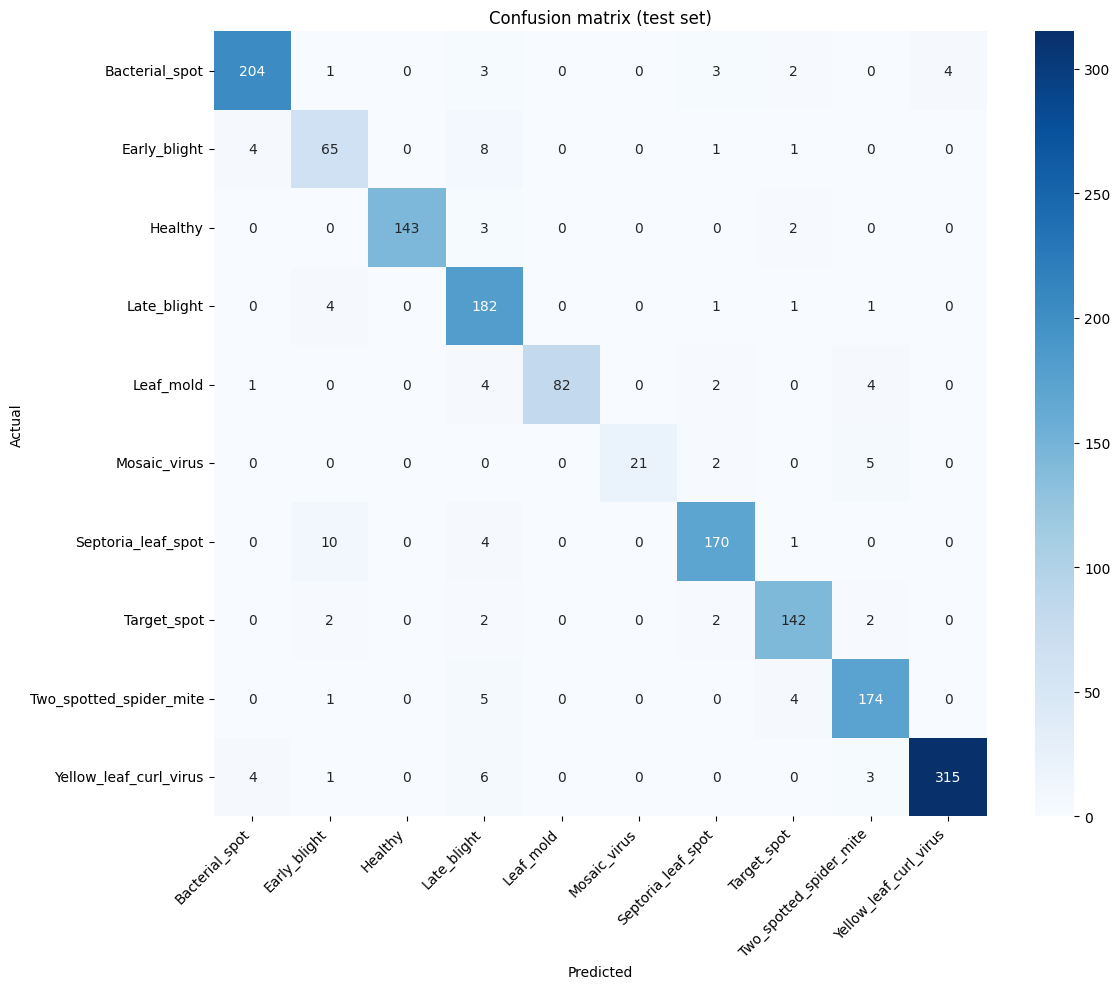

In [52]:
# Gather all test labels and predictions
y_true = []
y_pred = []
for images, labels in test_ds:
    preds = model.predict(images, verbose=0)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))
y_true = np.array(y_true)
y_pred = np.array(y_pred)

print(classification_report(y_true, y_pred, target_names=class_names, digits=3))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion matrix (test set)')
plt.tight_layout()
plt.show()

**Training curves**

Accuracy and loss on train and validation over epochs. If EarlyStopping is triggered, the number of epochs may be less than the maximum; the restored model is the best by validation loss.

In [53]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

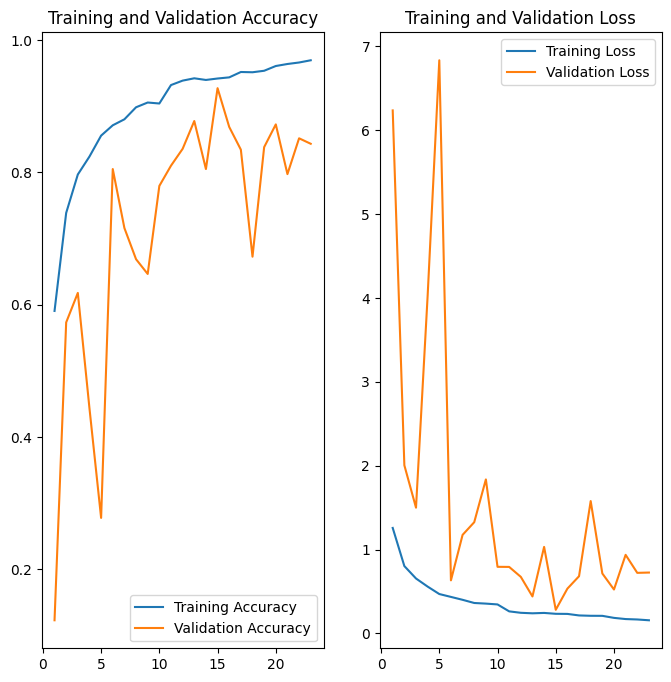

In [54]:
epochs_range = range(1, len(acc) + 1)
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

**Inference helper**

A `predict(model, img)` function that returns class name and confidence.

In [55]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


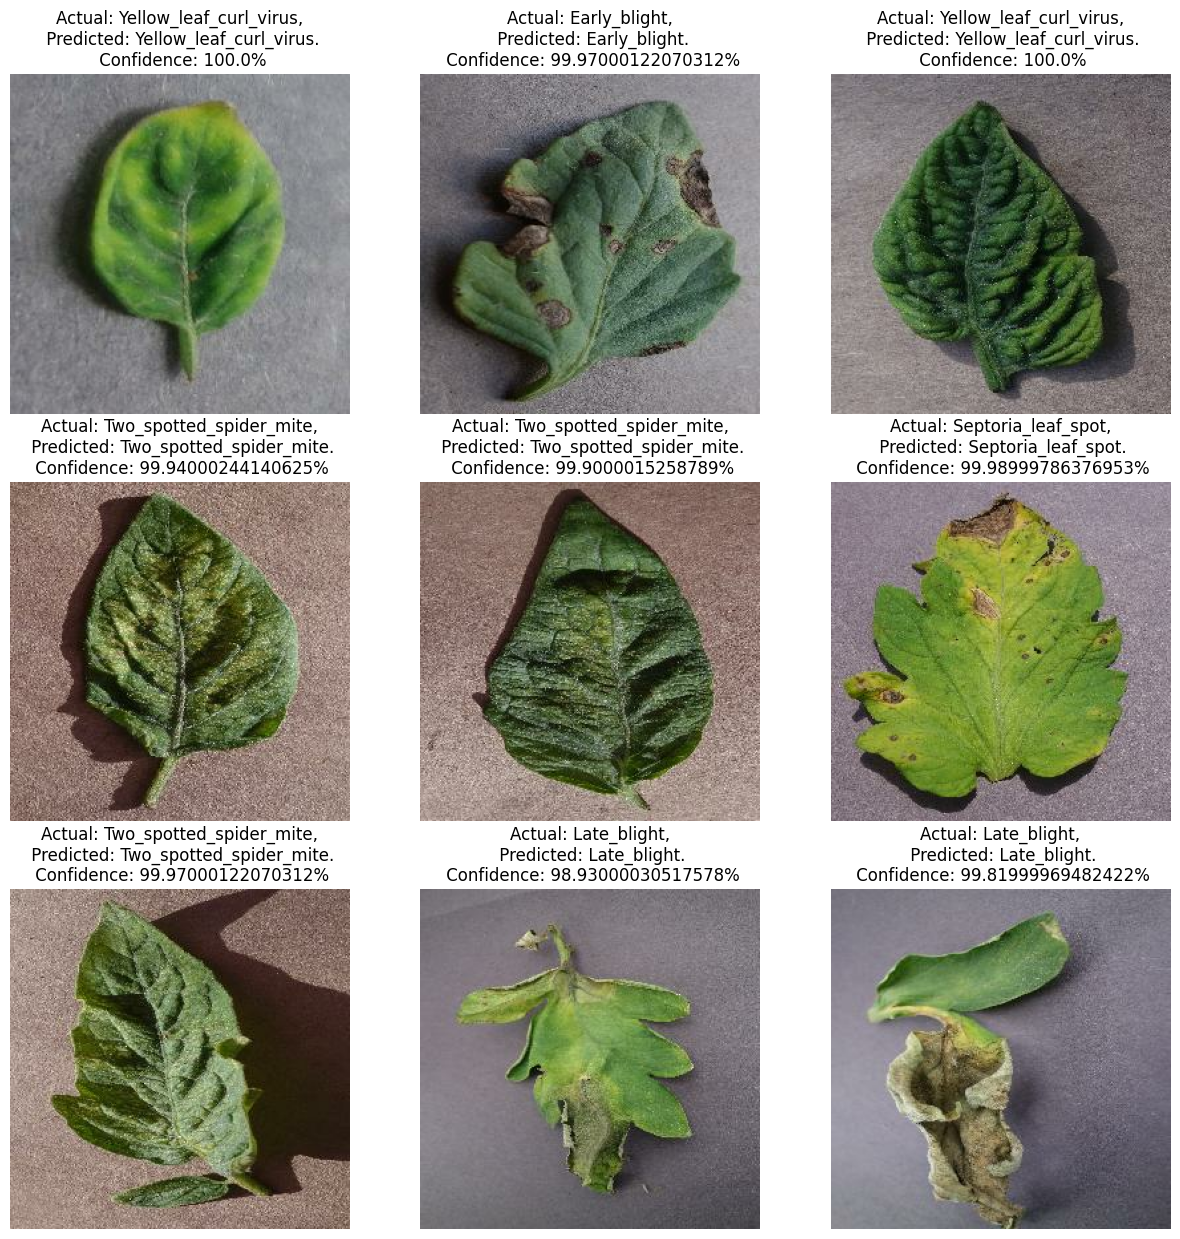

In [56]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

**Save for deployment**

Save the best model (from ModelCheckpoint if present, else current weights) as `recognition_model.keras` and `class_names.json` in `../models/` for the Flask app.

In [57]:
os.makedirs("../models", exist_ok=True)
# Save best checkpoint if it exists (from ModelCheckpoint), else current model
best_path = "../models/best_model.keras"
if os.path.isfile(best_path):
    model = tf.keras.models.load_model(best_path)
model.save("../models/recognition_model.keras")
with open("../models/class_names.json", "w") as f:
    json.dump(class_names, f)
print("Saved model and class_names to ../models/")

Saved model and class_names to ../models/
